## 1. Define Classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import chart_studio as py
import cufflinks as cf
cf.go_offline(connected=True)
from scipy import optimize 
from datetime import datetime
from dateutil.relativedelta import relativedelta
%matplotlib inline

try:
  import pandas_datareader.data as web
except:
  !pip install pip pandas-datareader
  import pandas_datareader.data as web

In [2]:
class Asset():
  def __init__(self, ticker, name, start, end):
    self.ticker = ticker
    self.name = name
    
    self.start = start
    self.end = end

    # 데이터 불러오기
    self.data = web.get_data_yahoo(self.ticker, self.start, self.end)
    self.date = self.data.index

    self.ratio = 0
    self.leverage = 0
    self.price = None
    self.change = None

  def put_ratio_leverage(self, ratio, leverage):
    self.ratio = ratio
    self.leverage = leverage

  def put_price_change(self):
    self.price = self.data['Adj Close']
    self.change = self.price.pct_change().to_list()

  def get_date(self):
    return self.date

  def get_change(self):
    return self.change

  def get_name(self):
    return self.name

In [3]:
class GMV_Asset(Asset):
    def __init__(self, ticker_list, start, end):
        self.ticker_list = ticker_list
        self.start = start
        self.end = end
        self.df = pd.DataFrame(columns=self.ticker_list)
        self.asset_list = []
        
    def create_df(self):
        for stock in self.ticker_list:
            asset = Asset(stock, stock, self.start, self.end)
            self.asset_list.append(asset)
            self.df[stock] = asset.data["Adj Close"]

            if stock == self.ticker_list[0]:
                self.df['date'] = asset.data.index
                self.df.set_index('date', inplace=True)
            
    def get_returns(self):
        return self.df.pct_change()

    def get_mean_returns(self):
        return self.get_returns().mean()
    
    def get_cov_matrix(self):
        return self.get_returns().cov()

In [67]:
class Portfolio():
    def __init__(self, name, assets, ratios, leverages, initial_balance, rebalancing_interval, gmv_weights=[]):
        self.name = name
        
        # list of class asset elements
        self.assets = assets

        # Assert all the dates for assets are equal and set portfolio start, end dates
        dates = [each.get_date() for each in self.assets]
        lendates = [len(each) for each in dates]
        assert len(set(lendates)) == 1
        self.date = dates[0]

        self.ratios = [each / sum(ratios) for each in ratios]
        self.leverages = leverages

        for i in range(len(self.assets)):
            self.assets[i].put_ratio_leverage(self.ratios[i], self.leverages[i])
            self.assets[i].put_price_change()

        self.initial_balance = initial_balance    
        self.rebalancing_interval = rebalancing_interval

        self.gmv_weights = []         # weights for gmv
        self.backtest_df = None
        self.backtest_result_df = None
        self.summary = None

    def backtest(self):
        # 첫 거래일
        balances = []
        
        asset_df = pd.DataFrame()
        for i in range(len(self.assets)):
            asset_df[i] = self.assets[i].data["Adj Close"]
        
        for i in range(len(self.assets)):
            balance = [self.initial_balance * self.ratios[i]]
            balances.append(balance)
        
        total_balance = [self.initial_balance]
        next_rebalancing = [self.date[0] + relativedelta(months=self.rebalancing_interval)]
        # 이후 거래일
        for i in range(1, len(self.date)):
            total_balance_tmp = 0
        
            if self.date[i] >= next_rebalancing[i-1]: # 리밸런싱하는 날
                next_rebalancing.append(next_rebalancing[i-1] + relativedelta(months=self.rebalancing_interval))
                
                if self.name == "GMV":
                    GMV = GMVPortfolio(asset_df[i:].pct_change().mean(), asset_df[i:].pct_change().cov(), num_portfolios=25000, risk_free_rate=0.0178)
                    self.gmv_weights = [round(i, 2) for i in GMV.min_variance().x]
#                     print("Current weight: ", self.gmv_weights)
                
                    # Asset 번호
                    for j in range(len(self.assets)):
                            balance = total_balance[i-1] * self.gmv_weights[j] * (1 + self.assets[j].get_change()[i])    
                            balances[j].append(balance)
                            total_balance_tmp += balances[j][i]
                else:
                    for j in range(len(self.assets)):
                            balance = total_balance[i-1] * self.ratios[j] * (1 + self.assets[j].get_change()[i] / 100)
                            balances[j].append(balance)
                            total_balance_tmp += balances[j][i]
            else:
                # 이전 리밸런싱 날짜랑 동일하게
                next_rebalancing.append(next_rebalancing[i-1])
                for j in range(len(self.assets)):
                    try:
                        balances[j].append(balances[j][i-1] * (1 + self.assets[j].get_change()[i] / 100))
                    except:
                        balances[j].append(balances[j][i-1])
                    total_balance_tmp += balances[j][i]
            total_balance.append(total_balance_tmp)

        df = pd.DataFrame()
        df['Date'] = self.date
        df.set_index('Date', inplace=True)
        df['Total'] = total_balance

        for i in range(len(self.assets)):
            df[self.assets[i].get_name()] = balances[i]
        
        print('Portfolio Backtest Complete')
        self.backtest_df = df
        return df

    def balance_result(self, balance):
        change = [0]
        cum_return = [0]
        prev_high = [0]
        prev_high_tmp = 0
        drawdown = [0]
        mdd = [0]
        mdd_tmp = 0
        CAGR = [0]
        stdev = [0]
        sharpe = [0]

        time_period = (self.date[-1] - self.date[0]).days / 365

        for i in range(1, len(self.date)):
            if balance[0] != 0:
                if balance[i-1] == 0:
                    change.append(0)
                    cum_return.append((balance[i] / balance[0] - 1) * 100)
                else:
                    change.append((balance[i] / balance[i-1] - 1) * 100)
                    cum_return.append((balance[i] / balance[0] - 1) * 100)
            elif balance[i] != 0:
                balance[0] = balance[i]
                change.append(0)
                cum_return.append(0)
            else:
                change.append(0)
                cum_return.append(0)

            if prev_high_tmp < cum_return[i]:
                prev_high_tmp = cum_return[i]
            else:
                prev_high_tmp = prev_high_tmp

            prev_high.append(prev_high_tmp)

            if balance[0] == 0:
                CAGR.append(0)
            else:
                CAGR.append(((balance[i] / balance[0]) ** (1 / float(time_period)) - 1) * 100)

            drawdown.append(((cum_return[i] + 100) / (prev_high[i] + 100) - 1) * 100)

            if mdd_tmp > drawdown[i]:
                mdd_tmp = drawdown[i]
            else:
                mdd_tmp = mdd_tmp

            mdd.append(mdd_tmp)
            stdev.append(np.std(change))
            
            if stdev[i] != 0:
                sharpe.append(np.sqrt(252) * np.mean(change) / np.std(change))
            else:
                sharpe.append(0)
                        
        return change, cum_return, prev_high, CAGR, drawdown, mdd, stdev, sharpe

    def backtest_result(self):
        df = pd.DataFrame()
        df['Date'] = self.date
        df.set_index('Date', inplace=True)
        label = ['Change', 'Cum. Return', 'Prev. High', 'CAGR', 'Drawdown', 'MDD', 'St. Dev', 'Sharpe']


        result = dict()
        for i in self.backtest_df.columns:
            result[i] = self.balance_result(self.backtest_df[i].to_list())
            df[f'{i} Balance'] = self.backtest_df[i].to_list()
            print(f'{i} Complete')

        for j in range(len(label)):
            for i in self.backtest_df.columns:
                df[f'{i} {label[j]}'] = result[i][j]

        self.backtest_result_df = df

        return df
    
    def periodic_result(self, mode):
        df = pd.DataFrame()

        for label in self.backtest_df.columns:
            return_points = []
            returns = []
            start_balance = []
            end_balance = []
            start = self.backtest_df[label].to_list()[0]
            
            if mode == 'annual':
                for i in range(1, len(self.date)):
                    if self.date[i].year != self.date[i-1].year:
                        return_points.append(self.date[i-1].year)
                        if start == 0:
                            returns.append(0)
                        else:
                            returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
                        start_balance.append(start)
                        end_balance.append(self.backtest_df[label].to_list()[i-1])
                        start = self.backtest_df[label].to_list()[i]
                    elif self.date[i] == self.date[-1]: # 마지막 거래일
                        return_points.append(self.date[i].year)
                        if start == 0:
                            returns.append(0)
                        else:
                            returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
                        start_balance.append(start)
                        end_balance.append(self.backtest_df[label].to_list()[i-1])
                df[f'{label} {mode.capitalize()} Return'] = returns
                
            elif mode == 'monthly':
                for i in range(1, len(self.date)):
                    if self.date[i].month != self.date[i-1].month:
                        return_points.append(self.date[i-1].strftime('%Y-%m'))
                        if start == 0:
                            returns.append(0)
                        else:
                            returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
                        start_balance.append(start)
                        end_balance.append(self.backtest_df[label].to_list()[i-1])
                        start = self.backtest_df[label].to_list()[i]
                    elif self.date[i] == self.date[-1]: # 마지막 거래일
                        return_points.append(self.date[i].strftime('%Y-%m'))
                        if start == 0:
                            returns.append(0)
                        else:
                            returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
                        start_balance.append(start)
                        end_balance.append(self.backtest_df[label].to_list()[i-1])
                df[f'{label} {mode.capitalize()} Return'] = returns

        df[f'Return {mode.capitalize()}'] = return_points
        df.set_index(f'Return {mode.capitalize()}', inplace=True)

        print(f'{mode.capitalize()} Result Complete')

        return df

    def get_name(self):
        return self.name

    def get_date(self):
        return self.date

    def get_backtest_result(self):
        return self.backtest_result_df

    def get_summary(self):
        # columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'MDD', 'St. Dev', 'Sharpe Ratio']
        
        detail = ''
        for i in range(len(self.assets)):
            name = self.assets[i].get_name()
            if self.name == "GMV":
                self.ratios = self.gmv_weights
            percentage = int(self.ratios[i] * 100)

            detail += f'{name} ({percentage}%, {self.leverages[i]}x) '

        self.summary = [detail, self.backtest_result_df['Total Balance'][0], self.backtest_result_df['Total Balance'][-1],
                                        str(round(self.backtest_result_df['Total CAGR'][-1], 2))+'%', str(round(self.backtest_result_df['Total MDD'][-1], 2))+'%',
                                        round(self.backtest_result_df['Total St. Dev'][-1], 2), round(self.backtest_result_df['Total Sharpe'][-1], 2)]
        
        return self.summary

In [68]:
class Visualize():
  def __init__(self, portfolios):
    self.portfolios = portfolios

     # Assert all the dates for assets are equal and set portfolio start, end dates
    dates = [each.get_date() for each in self.portfolios]
    lendates = [len(each) for each in dates]
    assert len(set(lendates)) == 1
    self.date = dates[0]

  def line_plot(self, result, title, return_type):
    data_list = []
    colm_list = []
    for i in range(len(self.portfolios)):
        data_list.append(self.portfolios[i].get_backtest_result().loc[:, f'Total {result}'])
        colm_list.append(self.portfolios[i].get_name())
    plot_df = pd.DataFrame(data_list).T
    plot_df.columns = colm_list
    plot_df.iplot(kind='line')
    
    
    
  def bar_plot(self, title, period):
    data_list = []
    colm_list = []
    for i in range(len(self.portfolios)):
      if period == 'annual':
        data_list.append(self.portfolios[i].periodic_result('annual').loc[:, 'Total Annual Return'])
        colm_list.append(self.portfolios[i].get_name())
      elif period == 'monthly':
        data_list.append(self.portfolios[i].periodic_result('monthly').loc[:, 'Total Monthly Return'])
        colm_list.append(self.portfolios[i].get_name())
    
    plot_df = pd.DataFrame(data_list).T
    plot_df.columns = colm_list
#     plot_df.plot.bar()
    plot_df.iplot(kind='bar', barmode='stack')

In [69]:
#class portfolio takes matrix of returns for every stock, and array of their weights
class GMVPortfolio:
    def __init__(self, mean_returns, cov_matrix, num_portfolios, risk_free_rate):
        self.mean_returns = mean_returns
        self.cov_matrix = cov_matrix
        self.num_portfolios = num_portfolios
        self.risk_free_rate = risk_free_rate

    def neg_sharpe_ratio(self, weights, mean_returns, cov_matrix, risk_free_rate):
        p_var, p_ret = self.portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        return -(p_ret - risk_free_rate) / p_var

    def max_sharpe_ratio(self):
        num_assets = len(self.mean_returns)
        args = (self.mean_returns, self.cov_matrix, self.risk_free_rate)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bound = (0.0,1.0)
        bounds = tuple(bound for asset in range(num_assets))
        result = optimize.minimize(self.neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                            method='SLSQP', bounds=bounds, constraints=constraints)
        return result
    
    def portfolio_volatility(self, weights, mean_returns, cov_matrix):
        return self.portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

    def min_variance(self):
        num_assets = len(self.mean_returns)
        args = (self.mean_returns, self.cov_matrix)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bound = (0.0,1.0)
        bounds = tuple(bound for asset in range(num_assets))

        result = optimize.minimize(self.portfolio_volatility, num_assets*[1./num_assets,], args=args,
                            method='SLSQP', bounds=bounds, constraints=constraints)

        return result

    def portfolio_return(self, weights):
        return self.portfolio_annualised_performance(weights, self.mean_returns, self.cov_matrix)[1]
    
    def efficient_return(self, target):
        num_assets = len(self.mean_returns)
        args = (self.mean_returns, self.cov_matrix)

        constraints = ({'type': 'eq', 'fun': lambda x: self.portfolio_return(x) - target},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0,1) for asset in range(num_assets))
        result = optimize.minimize(self.portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
        return result


    def efficient_frontier(self, returns_range):
        efficients = []
        for ret in returns_range:
            efficients.append(self.efficient_return(ret))
        return efficients
    
    def portfolio_annualised_performance(self, weights, mean_returns, cov_matrix):
        returns = np.sum(self.mean_returns*weights ) *252
        std = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights))) * np.sqrt(252)
        return std, returns
    
    def random_portfolios(self):
        results = np.zeros((3, self.num_portfolios))
        weights_record = []
        for i in range(self.num_portfolios):
            weights = np.random.random(self.mean_returns.shape[0])
            weights /= np.sum(weights)
            weights_record.append(weights)
            portfolio_std_dev, portfolio_return = self.portfolio_annualised_performance(weights, self.mean_returns, self.cov_matrix)
            results[0,i] = portfolio_std_dev
            results[1,i] = portfolio_return
            results[2,i] = (portfolio_return - self.risk_free_rate) / portfolio_std_dev
        return results, weights_record       
        
    def display_ef_with_selected_and_random(self, returns, cols):
        results, _ = self.random_portfolios()
        
        max_sharpe = self.max_sharpe_ratio()
        sdp, rp = self.portfolio_annualised_performance(max_sharpe['x'], self.mean_returns, self.cov_matrix)
        max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=cols,columns=['allocation'])
        max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
        max_sharpe_allocation = max_sharpe_allocation.T

        min_vol = self.min_variance()
        sdp_min, rp_min = self.portfolio_annualised_performance(min_vol['x'], self.mean_returns, self.cov_matrix)
        min_vol_allocation = pd.DataFrame(min_vol.x,index=cols,columns=['allocation'])
        min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
        min_vol_allocation = min_vol_allocation.T

        an_vol = np.std(returns) * np.sqrt(252)
        an_rt = self.mean_returns * 252

        print("-"*80)
        print("Maximum Sharpe Ratio Portfolio Allocation\n")
        print("Annualised Return:", round(rp,2))
        print("Annualised Volatility:", round(sdp,2))
        print("\n")
        print(max_sharpe_allocation)
        print("-"*80)
        print("Minimum Volatility Portfolio Allocation\n")
        print("Annualised Return:", round(rp_min,2))
        print("Annualised Volatility:", round(sdp_min,2))
        print("\n")
        print(min_vol_allocation)
        print("-"*80)
        print("Individual Stock Returns and Volatility\n")
        for i, txt in enumerate(cols):
            print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
        print("-"*80)

        fig, ax = plt.subplots(figsize=(10, 7))
        ax.scatter(an_vol,an_rt,marker='o',s=200)
        ax.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)

        for i, txt in enumerate(cols):
            ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
        ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
        ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

        target = np.linspace(rp_min, 0.34, 50)
        efficient_portfolios = self.efficient_frontier(target)
        ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
        ax.set_title('Portfolio Optimization with Individual Stocks')
        ax.set_xlabel('annualised volatility')
        ax.set_ylabel('annualised returns')
        ax.legend(labelspacing=0.8)        

## 2. GMV Portfolio

### 1) GMV - Calculation

In [73]:
gmv_portfolio_list = ['AMZN', 'AAPL', 'GOOGL', 'SBUX', 'SO', 'INTC', 'CSCO', 'MET']
gmv_asset = GMV_Asset(gmv_portfolio_list, '2016-01-02', '2020-10-31')
gmv_asset.create_df()

In [74]:
GMV = GMVPortfolio(gmv_asset.get_mean_returns(), gmv_asset.get_cov_matrix(), num_portfolios=25000, risk_free_rate=0.0178)
gmv_weights = [round(i, 2)for i in GMV.min_variance().x]

In [75]:
gmv_portfolio = Portfolio('GMV', gmv_asset.asset_list, gmv_weights, [1 for i in gmv_portfolio_list], 1000, 3)
gmv_backtest_df = gmv_portfolio.backtest()
backtest_result_df = gmv_portfolio.backtest_result()
gmv_annual_return_df = gmv_portfolio.periodic_result('annual')
gmv_monthly_return_df = gmv_portfolio.periodic_result('monthly')
gmv_portfolio.get_summary()

Portfolio Backtest Complete
Total Complete
AMZN Complete
AAPL Complete
GOOGL Complete
SBUX Complete
SO Complete
INTC Complete
CSCO Complete
MET Complete
Annual Result Complete
Monthly Result Complete


['AMZN (0%, 1x) AAPL (0%, 1x) GOOGL (0%, 1x) SBUX (26%, 1x) SO (45%, 1x) INTC (8%, 1x) CSCO (21%, 1x) MET (0%, 1x) ',
 1000.0,
 1116.630865971507,
 '2.31%',
 '-3.83%',
 0.26,
 0.57]

### 2) GMV - Efficient Frontier

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.35
Annualised Volatility: 0.26


             AMZN   AAPL  GOOGL  SBUX   SO  INTC  CSCO  MET
allocation  51.19  43.71    0.0   0.0  5.1   0.0   0.0  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.18
Annualised Volatility: 0.2


            AMZN  AAPL  GOOGL   SBUX     SO  INTC   CSCO  MET
allocation  17.9   0.0  12.27  15.08  42.71   0.0  12.05  0.0
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AMZN : annuaised return 0.37 , annualised volatility: 0.3
AAPL : annuaised return 0.36 , annualised volatility: 0.3
GOOGL : annuaised return 0.19 , annualised volatility: 0.26
SBUX : annuaised return 0.14 , annualised volatility: 0.27
SO : annuaised return 0.12 , annualised volati

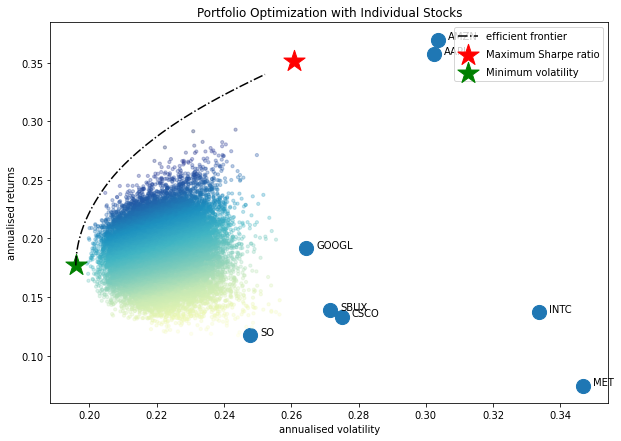

In [76]:
# GMV.display_calculated_ef_with_random()
# GMV.display_ef_with_selected()
GMV.display_ef_with_selected_and_random(gmv_asset.get_returns(), gmv_portfolio_list)

## 3. 60/40 Portfolio

In [77]:
asset1 = Asset('^IXIC', 'Asset 1', '2016-01-02', '2020-10-31')
asset2 = Asset('VUSTX', 'Asset 2', '2016-01-02', '2020-10-31')

sixty_forty_portfolio = Portfolio('60/40', [asset1, asset2], [6, 4], [1, 1], 1000, 3)
sixty_forty_backtest_df = sixty_forty_portfolio.backtest()
sixty_forty_backtest_result_df = sixty_forty_portfolio.backtest_result()
sixty_forty_annual_return_df = sixty_forty_portfolio.periodic_result('annual')
sixty_forty_monthly_return_df = sixty_forty_portfolio.periodic_result('monthly')
sixty_forty_summary = sixty_forty_portfolio.get_summary()

Portfolio Backtest Complete
Total Complete
Asset 1 Complete
Asset 2 Complete
Annual Result Complete
Monthly Result Complete


In [78]:
sixty_forty_summary

['Asset 1 (60%, 1x) Asset 2 (40%, 1x) ',
 1000.0,
 1007.1124404327659,
 '0.15%',
 '-0.18%',
 0.01,
 1.22]

## 4. All Weather Portfolio

In [79]:
asset3 = Asset('VTI', 'Asset 3', '2016-01-02', '2020-10-31')
asset4 = Asset('EDV', 'Asset 4', '2016-01-02', '2020-10-31')
asset5 = Asset('IEI', 'Asset 5', '2016-01-02', '2020-10-31')
asset6 = Asset('GLD', 'Asset 6', '2016-01-02', '2020-10-31')
asset7 = Asset('GSG', 'Asset 7', '2016-01-02', '2020-10-31')

awf_portfolio = Portfolio('All Weather', [asset3, asset4, asset5, asset6, asset7], [3, 4, 1.5, 0.75, 0.75], [1, 1, 1, 1, 1], 1000, 3)
awf_backtest_df = awf_portfolio.backtest()
awf_backtest_result_df = awf_portfolio.backtest_result()
awf_annual_return_df = awf_portfolio.periodic_result('annual')
awf_monthly_return_df = awf_portfolio.periodic_result('monthly')
awf_summary = awf_portfolio.get_summary()

Portfolio Backtest Complete
Total Complete
Asset 3 Complete
Asset 4 Complete
Asset 5 Complete
Asset 6 Complete
Asset 7 Complete
Annual Result Complete
Monthly Result Complete


In [80]:
awf_summary

['Asset 3 (30%, 1x) Asset 4 (40%, 1x) Asset 5 (15%, 1x) Asset 6 (7%, 1x) Asset 7 (7%, 1x) ',
 1000.0,
 1004.7449460225349,
 '0.1%',
 '-0.15%',
 0.01,
 1.19]

## 5. Result Visualization

In [87]:
aw_64 = Visualize([gmv_portfolio, sixty_forty_portfolio, awf_portfolio])
# aw_64 = Visualize([sixty_forty_portfolio, awf_portfolio])

In [88]:
aw_64.line_plot('Drawdown', 'GMV VS 60/40 VS All Weather Drawdown', 'linear')

In [89]:
aw_64.bar_plot('GMV VS 60/40 VS All Weather Monthly Return', 'monthly')

Monthly Result Complete
Monthly Result Complete
Monthly Result Complete


In [92]:
gmv_portfolio.periodic_result('monthly')

Monthly Result Complete


,Total Monthly Return,AMZN Monthly Return,AAPL Monthly Return,GOOGL Monthly Return,SBUX Monthly Return,SO Monthly Return,INTC Monthly Return,CSCO Monthly Return,MET Monthly Return
Return Monthly,,,,,,,,,
2016-01,0.000260,-0.070137,0,0.006059,0.046220,0.040135,0.000000,-0.100278,0.000000
2016-02,-0.017151,-0.032778,0,-0.069183,-0.046411,-0.022863,0.000000,0.115533,0.000000
2016-03,0.051732,0.026658,0,0.028529,-0.004898,0.086079,0.000000,0.060219,0.000000
2016-04,-0.708261,10.362245,0,-0.625533,5.253378,-5.034748,0.000000,-9.318175,0.000000
2016-05,0.014758,0.057287,0,0.048040,-0.039735,-0.006980,0.000000,0.061385,0.000000
2016-06,0.031025,-0.003828,0,-0.060001,0.042865,0.079613,0.000000,-0.005151,0.000000
2016-07,-0.815408,5.429318,0,-8.904643,0.307777,-2.058648,0.000000,-0.312173,0.000000
2016-08,-0.015120,0.002199,0,-0.013773,-0.020346,-0.032868,0.000000,0.023209,0.000000
2016-09,0.015829,0.084772,0,0.016778,-0.038434,0.003778,0.000000,0.005452,0.000000
